## Importing data and libraries

In [195]:
# Import necessary libraries
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
import requests
from tabulate import tabulate


In [196]:
# Initialize a BigQuery client
client = bigquery.Client(project='container-testing-381309')

# Function to execute BigQuery and return results as a DataFrame
def run_bigquery(query):
    query_job = client.query(query)
    return query_job.to_dataframe()

# Read user_info table
user_info_query = """
SELECT *
FROM `container-testing-381309.telegram.user_info`
"""
user_info_df = run_bigquery(user_info_query)

# Read chat_history table
chat_history_query = """
SELECT 
    ch.*,
    COALESCE(ui.bot, FALSE) as is_bot
FROM `container-testing-381309.telegram.chat_history` ch
LEFT JOIN `container-testing-381309.telegram.user_info` ui
ON ch.from_user = ui.id
"""
chat_history_df = run_bigquery(chat_history_query)

# Read chat_info table
chat_info_query = """
SELECT *
FROM `container-testing-381309.telegram.chat_info`
"""

chat_info_df = run_bigquery(chat_info_query)

#before fixing this in ETL logic, chat history was automatically adding a -100 prefix to chat_id
#To have identical chat_id in all tables, we need to remove this prefix from chat_id in chat_history table
# Remove the "-100" prefix from chat_id
chat_history_df['id'] = chat_history_df['id'].apply(lambda x: str(x)[4:] if str(x).startswith('-100') else str(x))
chat_history_df['id'] = chat_history_df['id'].astype(int)
chat_history_df = chat_history_df.merge(chat_info_df, on='id', how='left')
chat_history_df['date'] = pd.to_datetime(chat_history_df['date'])

# Merge the chat_info table to get chat names

print(chat_history_df.head())


       id                      date  from_user  \
0  755893 2024-08-21 16:20:49+00:00  169601997   
1  755892 2024-08-21 15:49:07+00:00  146679674   
2  755938 2024-08-21 19:09:03+00:00  438257687   
3  755937 2024-08-21 19:08:48+00:00  438257687   
4  755940 2024-08-21 19:11:28+00:00  254671781   

                                                text     sender     chat_id  \
0  Hi. Can someone give me some example for using...  169601997  1030379032   
1  I have functionality in my bot to handle custo...  146679674  1030379032   
2  Hey. Please provide a minimal working example ...  438257687  1030379032   
3                                    Send MWE please  438257687  1030379032   
4                                   After i go to pc  254671781  1030379032   

   is_reply  views  forwards  replies  ...    via_bot reply_to_msg_id  \
0     False      0         0        3  ...          0               0   
1     False      0         0        0  ...          0               0   
2    

In [197]:
#Separate bot and human messages  also for further analysis
bot_messages_df = chat_history_df[chat_history_df['is_bot'] == True]
human_messages_df = chat_history_df[chat_history_df['is_bot'] == False]

In [198]:
def set_custom_color_scheme():
    # Define a custom color palette with muted shades of green and yellow
    custom_palette = ["#a3d977", "#6bbf59", "#d7e87e", "#97c95d", "#d0e0a3", "#88b98b"]
    
    # Apply the color palette to Seaborn
    sns.set_palette(custom_palette)
    
    # Apply the color palette to Matplotlib
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_palette)
    
    # Set other Matplotlib default styles with black text
    plt.rcParams['axes.labelcolor'] = '#000000'  # Black for axis labels
    plt.rcParams['xtick.color'] = '#000000'      # Black for x-ticks
    plt.rcParams['ytick.color'] = '#000000'      # Black for y-ticks
    plt.rcParams['grid.color'] = '#d7e87e'       # Soft yellow for grid lines
    plt.rcParams['text.color'] = '#000000'       # Black for all text
    plt.rcParams['figure.facecolor'] = '#ffffff' # White background for figure
    plt.rcParams['axes.facecolor'] = '#ffffff'   # White background for axes

# Apply the color scheme to your plots
set_custom_color_scheme()


## Analysis of different statistics

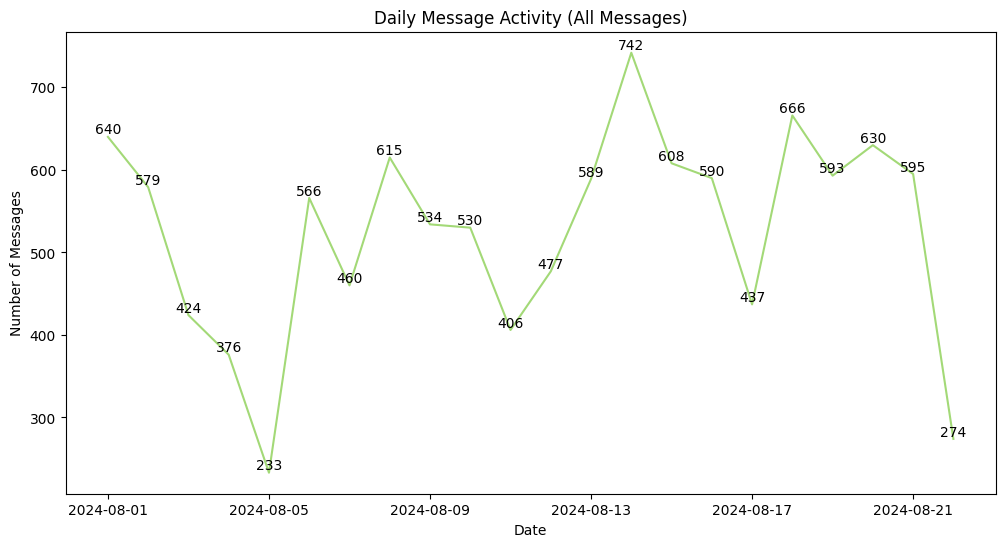

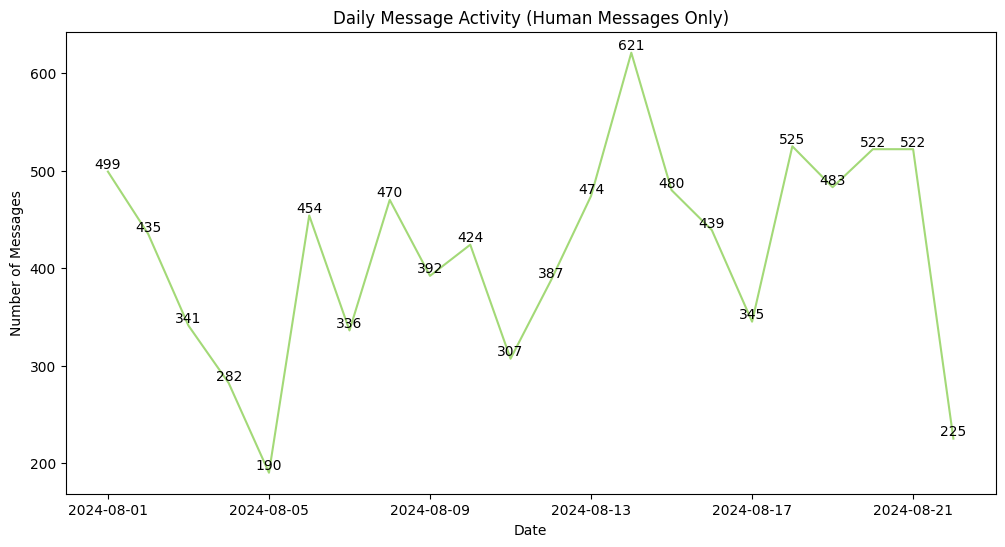

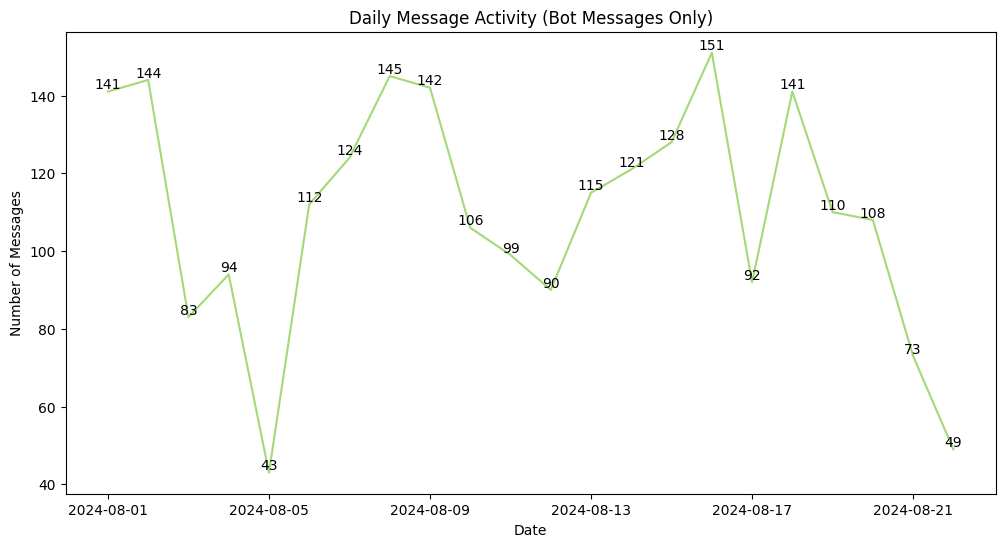

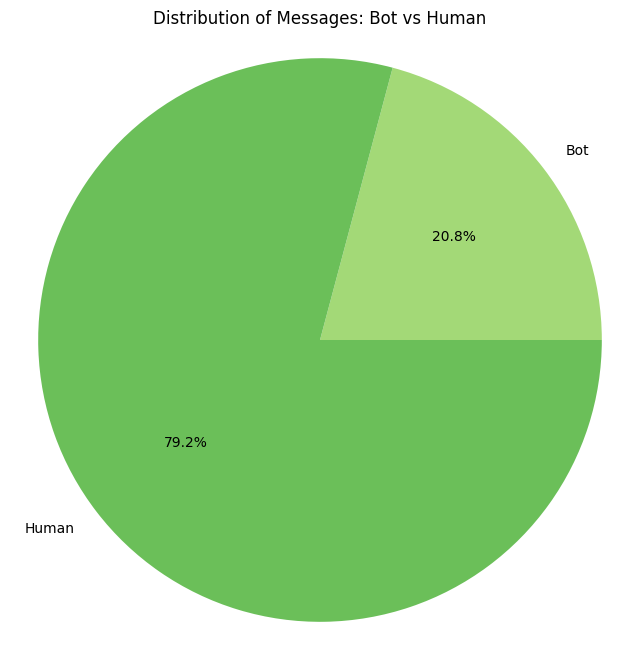

In [199]:

def plot_daily_activity(df, title):
    # Group by date and count the number of messages
    daily_activity = df.groupby(df['date'].dt.date).size()
    
    # Plot the data
    plt.figure(figsize=(12, 6))
    ax = daily_activity.plot()
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Number of Messages')
    
    # Annotate each point on the graph with its value
    for i, value in enumerate(daily_activity):
        ax.text(daily_activity.index[i], value, str(value), ha='center', va='bottom')

    # Show the plot
    plt.show()


def plot_bot_human_distribution():
    message_counts = chat_history_df['is_bot'].value_counts()
    bot_messages = message_counts.get(True, 0)
    human_messages = message_counts.get(False, 0)

    plt.figure(figsize=(8, 8))
    plt.pie([bot_messages, human_messages], labels=['Bot', 'Human'], autopct='%1.1f%%')
    plt.title('Distribution of Messages: Bot vs Human')
    plt.axis('equal')
    plt.show()


# Plot daily activity for all messages
plot_daily_activity(chat_history_df, 'Daily Message Activity (All Messages)')

# Plot daily activity for human messages only
plot_daily_activity(human_messages_df, 'Daily Message Activity (Human Messages Only)')

# Plot daily activity for bot messages only
plot_daily_activity(bot_messages_df, 'Daily Message Activity (Bot Messages Only)')

# Plot distribution of bot vs human messages
plot_bot_human_distribution()    

Message activity over time

In [200]:
# Calculate the average number of messages per day for bot and human
#human
avg_human_messages = human_messages_df.groupby(human_messages_df['date'].dt.date).size().mean()
print(f"Average number of human messages per day: {avg_human_messages:.2f}")

#bot
avg_bot_messages = bot_messages_df.groupby(bot_messages_df['date'].dt.date).size().mean()
print(f"Average number of bot messages per day: {avg_bot_messages:.2f}")

Average number of human messages per day: 416.05
Average number of bot messages per day: 109.59


Top active users - all chats together

/var/folders/gf/7_bh9lyn3fb01vysrym11jqh0000gn/T/ipykernel_62609/754164155.py:33: UserWarning: Glyph 8295 (\N{RIGHT-TO-LEFT ISOLATE}) missing from current font.
  plt.tight_layout()
/Users/ajda/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8295 (\N{RIGHT-TO-LEFT ISOLATE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


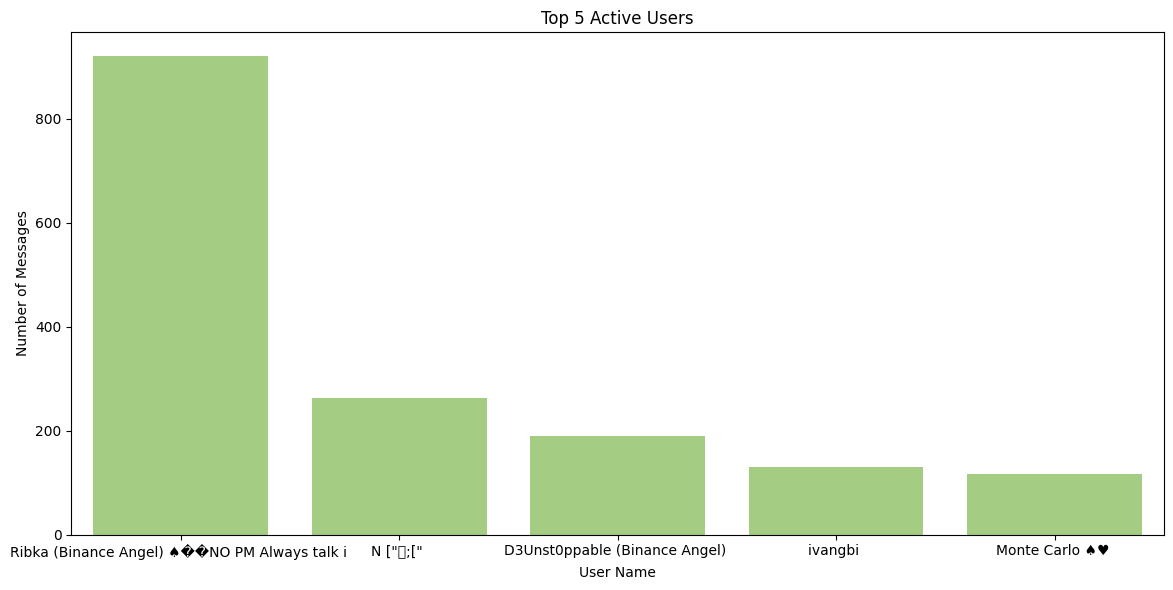

                                        full_name  message_count
0  Ribka (Binance Angel) ♠️��NO PM Always talk i             920
1                                       N ["⁧;["             262
2                  D3Unst0ppable (Binance Angel)             189
3                                        ivangbi             130
4                               Monte Carlo ♠️♥️             117

Names of the top 5 most active chats:
Chat ID: 1146170349, Name: Binance English
Chat ID: 1030379032, Name: >>> telegram.Bot()
Chat ID: 1242127973, Name: LobsterDAO ��

Detailed information about top 5 users:
+---------------------------------+----------------------------------------------------+
| User ID                         | 611740329                                          |
+---------------------------------+----------------------------------------------------+
| Name                            | Ribka (Binance Angel) ♠️��NO PM Always talk i None |
+---------------------------------+---------

In [201]:
# Function to adjust chat IDs
def normalize_chat_id(chat_id):
    chat_id_str = str(chat_id)
    if chat_id_str.startswith('-100'):
        return int(chat_id_str[4:])
    return int(chat_id)

# Normalize chat IDs in human_messages_df
human_messages_df.loc[:, 'chat_id'] = human_messages_df['chat_id'].apply(normalize_chat_id)

# Normalize chat IDs in chat_info_df
chat_info_df.loc[:, 'id'] = chat_info_df['id'].apply(normalize_chat_id)

# Identify the top 5 users by message count
top_users = human_messages_df['from_user'].value_counts().head(5)
top_users_df = pd.DataFrame({'user_id': top_users.index, 'message_count': top_users.values})

# Merge with user_info_df to get user names
top_users_with_names = pd.merge(top_users_df, user_info_df[['id', 'first_name', 'last_name']], left_on='user_id', right_on='id', how='left')

# Create full name
top_users_with_names['full_name'] = top_users_with_names['first_name'] + " " + top_users_with_names['last_name'].fillna('')

# Sort by message count descending
top_users_with_names = top_users_with_names.sort_values('message_count', ascending=False)

# Plot top 5 active users with names
plt.figure(figsize=(12, 6))
sns.barplot(x='full_name', y='message_count', data=top_users_with_names)
plt.title('Top 5 Active Users')
plt.xlabel('User Name')
plt.ylabel('Number of Messages')
plt.tight_layout()
plt.show()

# Print the data for verification
print(top_users_with_names[['full_name', 'message_count']])

# Analyze user participation across different chats
user_chat_participation = human_messages_df[human_messages_df['from_user'].isin(top_users.index)]
user_chat_counts = user_chat_participation.groupby('from_user')['chat_id'].nunique().sort_values(ascending=False)

# Create activity across chats, used further in the analysis
user_chat_activity = user_chat_participation.groupby(['from_user', 'chat_id']).size().unstack(fill_value=0)
user_chat_activity = user_chat_activity.reindex(columns=user_chat_activity.sum().sort_values(ascending=False).index)

# Get chat names for the top 5 chats
top_5_chats = user_chat_activity.sum().sort_values(ascending=False).head(5).index
chat_names = chat_info_df[chat_info_df['id'].isin(top_5_chats)].set_index('id')['name']

print("\nNames of the top 5 most active chats:")
for chat_id in top_5_chats:
    print(f"Chat ID: {chat_id}, Name: {chat_names.get(chat_id, 'Unknown')}")

# Get user info for top 5 users
top_user_info = user_info_df[user_info_df['id'].isin(top_users.index)].set_index('id')

print("\nDetailed information about top 5 users:")

for user_id in top_users.index[:5]:
    user = top_user_info.loc[user_id]
    
    # User info table
    user_info = [
        ["User ID", user_id],
        ["Name", f"{user['first_name']} {user['last_name']}"],
        ["Username", user['username']],
        ["Total messages", top_users[user_id]],
        ["Number of chats participated in", user_chat_counts[user_id]]
    ]
    print(tabulate(user_info, tablefmt="grid"))
    
    # Top 3 chats table
    print("\nTop 3 most active chats:")
    top_3_chats = user_chat_activity.loc[user_id].sort_values(ascending=False).head(3)
    chat_info = [
        [chat_id, chat_names.get(chat_id, 'Unknown'), message_count]
        for chat_id, message_count in top_3_chats.items()
    ]
    print(tabulate(chat_info, headers=["Chat ID", "Chat Name", "Messages"], tablefmt="grid"))
    
    print("\n" + "="*50 + "\n")  # Separator between users


Top 5 users in each chat

/Users/ajda/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8295 (\N{RIGHT-TO-LEFT ISOLATE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


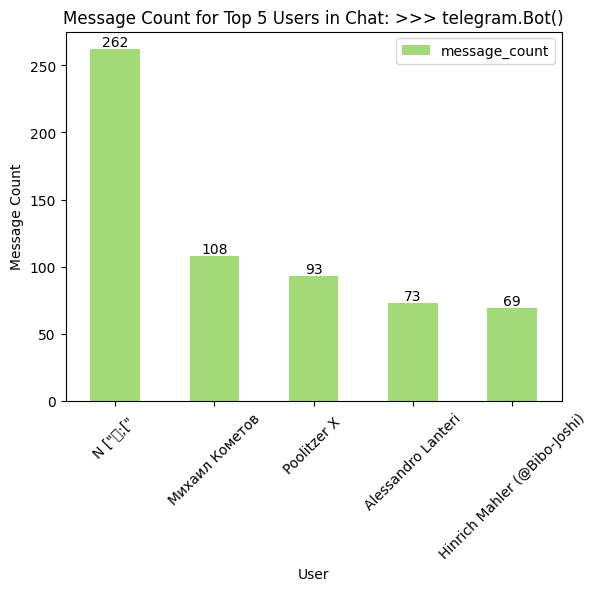

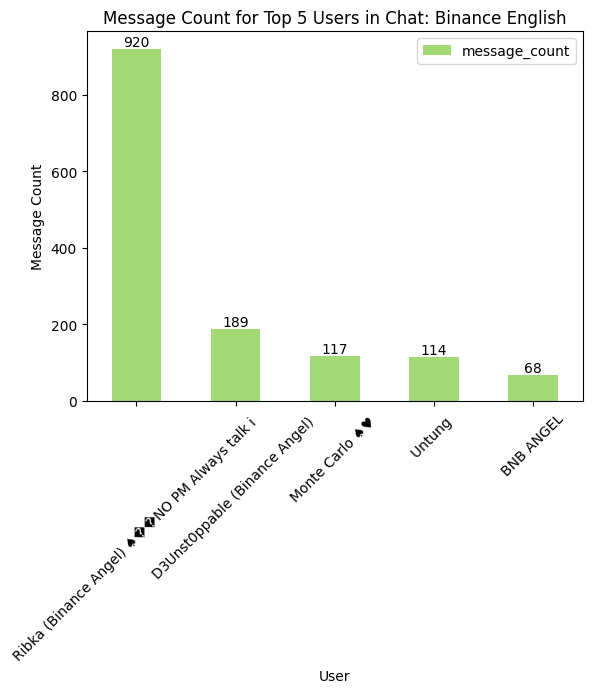

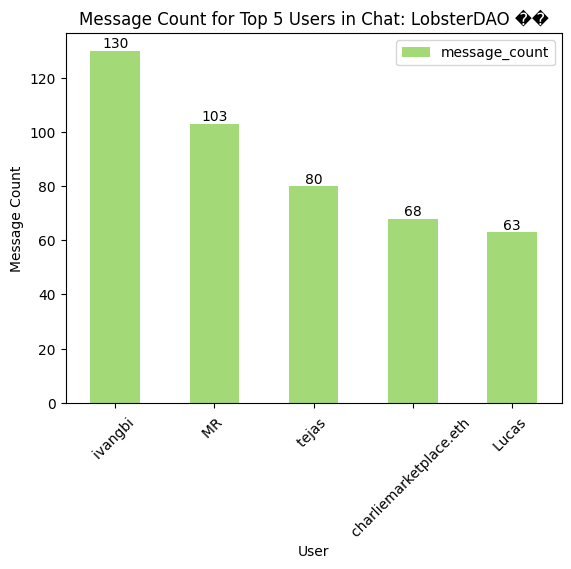

In [202]:
# Find the top users in each chat
top_users = human_messages_df.groupby(['chat_id', 'from_user'])['date'].count().reset_index(name='message_count')
top_users = top_users.sort_values(['chat_id', 'message_count'], ascending=[True, False])

# Merge with chat_info_df and user_info_df
top_users_with_names = pd.merge(top_users, chat_info_df[['id', 'name']], left_on='chat_id', right_on='id', how='left')
top_users_with_names = pd.merge(top_users_with_names, user_info_df[['id', 'first_name', 'last_name']], left_on='from_user', right_on='id', how='left')
top_users_with_names['full_name'] = top_users_with_names['first_name'] + " " + top_users_with_names['last_name'].fillna('')

# Print the top 5 users for each chat and create a histogram
for chat_id, chat_users in top_users_with_names.groupby('chat_id'):
    top_5_users = chat_users[['full_name', 'message_count']].head(5)
    # Create a histogram for the top 5 users in this chat
    ax = top_5_users.plot(x='full_name', y='message_count', kind='bar')
    plt.title(f"Message Count for Top 5 Users in Chat: {chat_users['name'].unique()[0]}")
    plt.xlabel("User")
    plt.ylabel("Message Count")
    plt.xticks(rotation=45)
    
    # Add numbers on each bar
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    
    plt.show()
    print()


Message lenght destribution

count    11564.000000
mean       125.169492
std        258.483608
min          0.000000
25%         19.000000
50%         52.500000
75%        132.250000
max       4107.000000
Name: message_length, dtype: float64


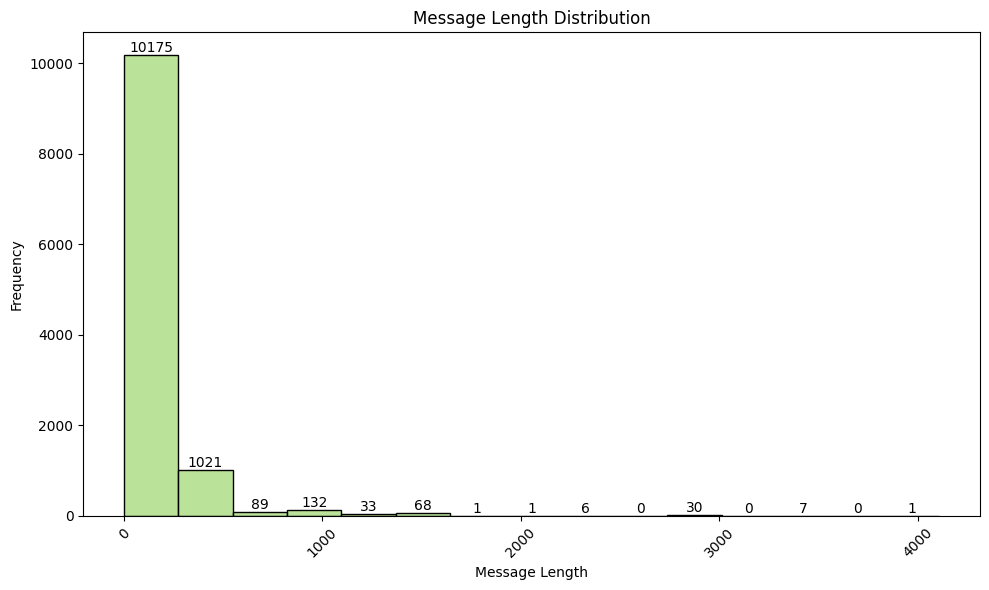

In [203]:
chat_history_df['message_length'] = chat_history_df['text'].astype(str).str.len()

print(chat_history_df['message_length'].describe())

plt.figure(figsize=(10, 6))
ax = sns.histplot(chat_history_df['message_length'], bins=15, kde=False)
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')

# Add numbering on top of each bar
for i, p in enumerate(ax.patches):
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Increase the number of ticks on the x-axis
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Word cloud for each chat

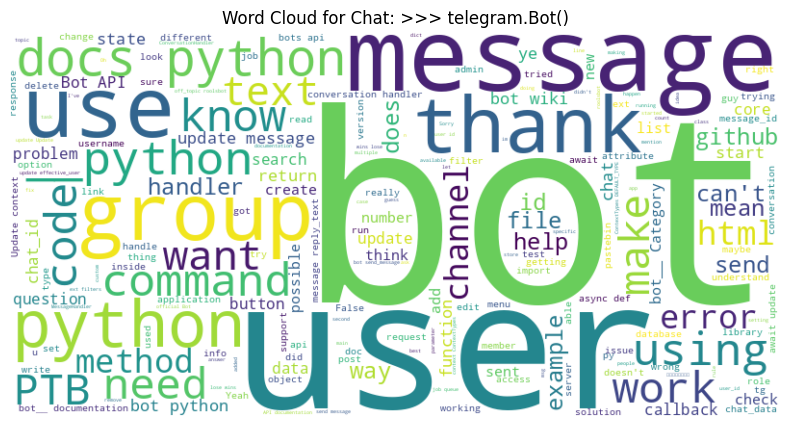

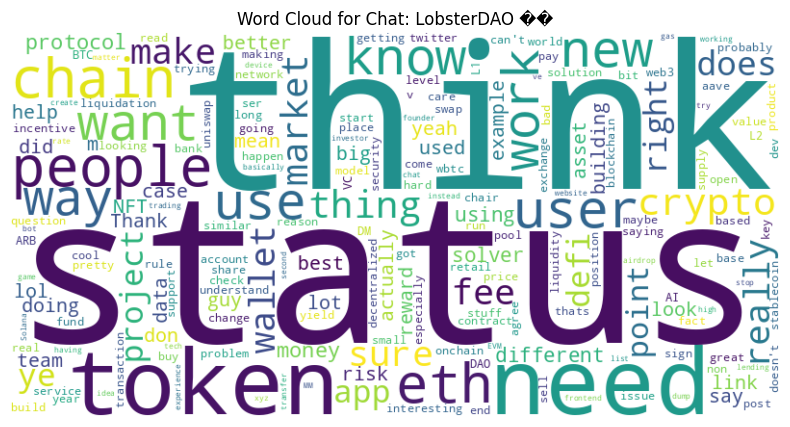

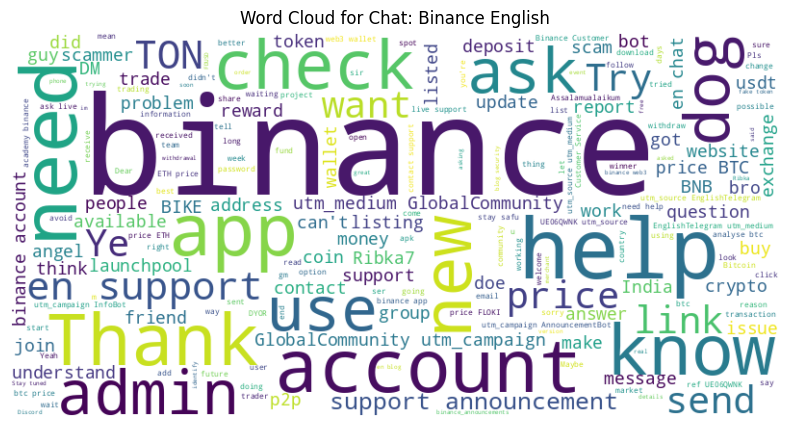

In [204]:
def create_word_cloud(text, stopwords, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def cloud_for_each_chat(df, chat_info):
    # Create stopwords
    stopwords = set(CountVectorizer(stop_words='english').get_stop_words())
    stopwords = stopwords.union(set(['http', 'https', 'www', 'com', 'org', 'net', 'telegram', 't', 'com','x','like','S','just','hello',
                                     'hi','hey','ok','good','morning','evening','night','day','time','today','tomorrow','yesterday',
                                     'dont',"don't", "i'm"]))
    
    # Rename columns in chat_info
    chat_info.columns = ['id', 'chat_name', 'members_count']
    chat_info['id'] = chat_info['id'].astype(int)  # Ensure id is integer for merging
    
    # Merge DataFrames
    merged_df = pd.merge(df, chat_info, left_on='chat_id', right_on='id', how='left')
    
    # Create word cloud for each unique chat
    for chat_id in merged_df['chat_id'].unique():
        chat_messages = merged_df[merged_df['chat_id'] == chat_id]
        chat_name = chat_messages['chat_name'].iloc[0]
        chat_text = ' '.join(chat_messages['text'].astype(str))
        
        create_word_cloud(chat_text, stopwords, f'Word Cloud for Chat: {chat_name}')

# Convert chat_info to DataFrame if it's not already
if not isinstance(chat_info, pd.DataFrame):
    chat_info = pd.DataFrame(chat_info)

# Call the function
cloud_for_each_chat(human_messages_df, chat_info)

User engagement summary -- something here i am not handeling right

In [205]:

def is_valid(value):
    if pd.isna(value):
        return False
    if isinstance(value, (int, float)):
        return value != 0
    if isinstance(value, str):
        return value.strip() != '' and value != '0'
    return True

# Apply the is_valid function to relevant columns
columns_to_check = ['views', 'forwards', 'reactions', 'media']
for col in columns_to_check:
    chat_history_df[f'{col}_valid'] = chat_history_df[col].apply(is_valid)

# Aggregate user engagement statistics
user_engagement = chat_history_df.groupby('from_user').agg({
    'id': 'count',              # Total messages
    'media_valid': 'sum',       # Count of messages with valid media
    'reactions_valid': 'sum',   # Count of messages with valid reactions
    'views_valid': 'sum',       # Count of messages with valid views
    'forwards_valid': 'sum',    # Count of messages with valid forwards
    'views': lambda x: x[x != 0].mean()  # Average views (excluding zeros)
}).reset_index()

# Rename columns for clarity
user_engagement.columns = [
    'user_id',
    'total_messages',
    'media_messages',
    'messages_with_reactions',
    'messages_with_views',
    'messages_with_forwards',
    'avg_views'
]

print("\nUser Engagement Summary:")
print(user_engagement.describe())

# Optional: Print the first few rows to verify
print("\nFirst few rows of User Engagement:")
print(user_engagement.head())


User Engagement Summary:
                 user_id  total_messages  media_messages  \
count             2132.0     2132.000000     2132.000000   
mean   3752933458.584428        5.421201        0.488743   
std    2739581282.009122       42.299416        8.295027   
min             355676.0        1.000000        0.000000   
25%        1005725908.25        1.000000        0.000000   
50%         5084534233.0        1.000000        0.000000   
75%         6421241968.5        3.000000        0.000000   
max         7499392850.0     1581.000000      331.000000   

       messages_with_reactions  messages_with_views  messages_with_forwards  
count              2132.000000          2132.000000             2132.000000  
mean                  0.666041             0.007036                0.007036  
std                   3.443737             0.124242                0.124242  
min                   0.000000             0.000000                0.000000  
25%                   0.000000             

Actvivity heatmap

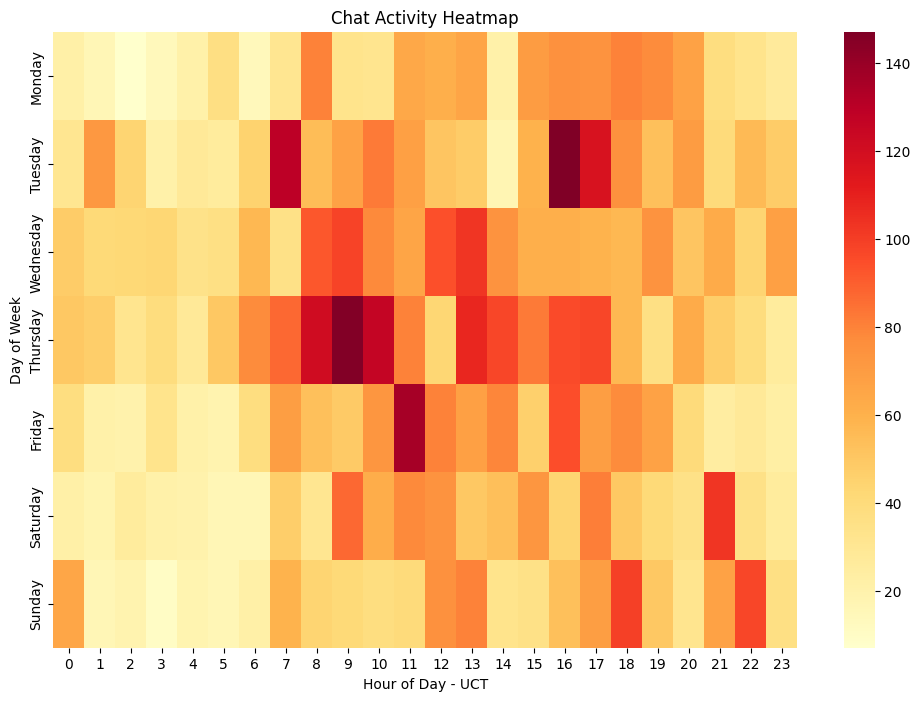

In [206]:
# Suppress the SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# Create new columns for hour and day of week
human_messages_df['hour'] = human_messages_df['date'].dt.hour
human_messages_df['day_of_week'] = human_messages_df['date'].dt.day_name()

# Create the activity heatmap
activity_heatmap = human_messages_df.groupby(['day_of_week', 'hour']).size().unstack()

# Check if all days of the week are present in the correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
if set(activity_heatmap.index) == set(day_order):
    activity_heatmap = activity_heatmap.reindex(day_order)
else:
    print("Warning: Not all days of the week are present in the data.")

# Create the heatmap plot
plt.figure(figsize=(12, 8))
sns.heatmap(activity_heatmap, cmap='YlOrRd')
plt.title('Chat Activity Heatmap')
plt.xlabel('Hour of Day - UCT')
plt.ylabel('Day of Week')
plt.show()

Destribution of a bot users

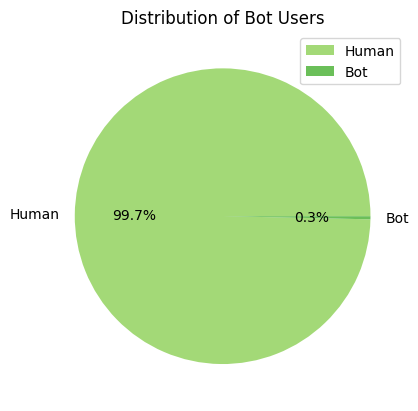

In [207]:
bot_users = user_info_df['bot'].value_counts()
bot_users_df = pd.DataFrame({'is_bot': bot_users.index, 'count': bot_users.values})
bot_users_df['is_bot'] = bot_users_df['is_bot'].map({True: 'Bot', False: 'Human'})
bot_users_df.plot(kind='pie', y='count', labels=bot_users_df['is_bot'], autopct='%1.1f%%')
plt.title('Distribution of Bot Users')
plt.ylabel('')
plt.show()

Moste active chats


Top 5 Most Active Chats:
                 name  message_count  unique_user_count
0     Binance English           5218               1463
1       LobsterDAO ��           2006                383
2  >>> telegram.Bot()           1929                279


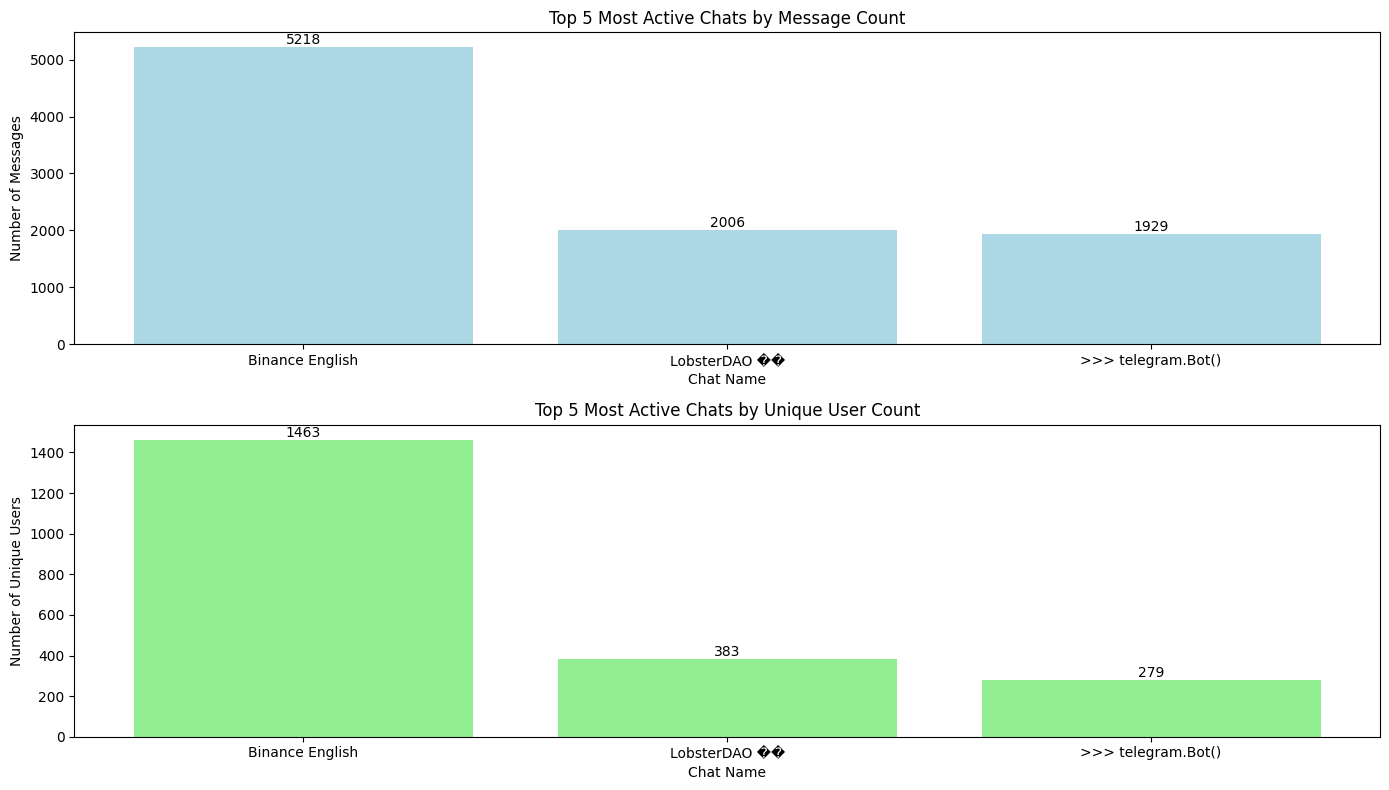

In [208]:
human_messages_df['chat_id'] = human_messages_df['chat_id'].apply(lambda x: str(x)[4:] if str(x).startswith('-100') else str(x)).astype(int)

chat_counts = human_messages_df['chat_id'].value_counts().reset_index()
chat_counts.columns = ['id', 'message_count']

unique_users_df = human_messages_df.groupby('chat_id')['from_user'].nunique().reset_index()
unique_users_df.columns = ['id', 'unique_user_count']

chat_stats = pd.merge(chat_counts, unique_users_df, on='id', how='left')

chat_stats = pd.merge(chat_stats, chat_info_df[['id', 'name']], on='id', how='left')

top_chats = chat_stats.sort_values('message_count', ascending=False).head(5)

print("\nTop 5 Most Active Chats:")
print(top_chats[['name', 'message_count', 'unique_user_count']])

plt.figure(figsize=(14, 8))

# Plot for message count
plt.subplot(2, 1, 1)
plt.bar(top_chats['name'], top_chats['message_count'], color='lightblue')
plt.title('Top 5 Most Active Chats by Message Count')
plt.xlabel('Chat Name')
plt.ylabel('Number of Messages')
for i, count in enumerate(top_chats['message_count']):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Plot for unique user count
plt.subplot(2, 1, 2)
plt.bar(top_chats['name'], top_chats['unique_user_count'], color='lightgreen')
plt.title('Top 5 Most Active Chats by Unique User Count')
plt.xlabel('Chat Name')
plt.ylabel('Number of Unique Users')
for i, count in enumerate(top_chats['unique_user_count']):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Sentimental and emotional analysis of group texts

In [209]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Function to download NRC Emotion Lexicon
def download_nrc_lexicon():
    url = "https://raw.githubusercontent.com/dinbav/LeXmo/master/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
    response = requests.get(url)
    lines = response.text.split("\n")
    lexicon = {}
    for line in lines:
        parts = line.strip().split("\t")
        if len(parts) == 3:
            word, emotion, value = parts
            if word not in lexicon:
                lexicon[word] = {}
            lexicon[word][emotion] = int(value)
    return lexicon

# Download the NRC Emotion Lexicon
nrc_lexicon = download_nrc_lexicon()

# Function to get emotions from text
def get_emotions(text):
    if pd.isna(text) or not isinstance(text, str):
        return Counter()
    words = nltk.word_tokenize(text.lower())
    emotions = Counter()
    for word in words:
        if word in nrc_lexicon:
            emotions.update({emotion: score for emotion, score in nrc_lexicon[word].items() if score > 0})
    return emotions

# Function to get sentiment
def get_sentiment(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0
    return TextBlob(text).sentiment.polarity

[nltk_data] Downloading package punkt to /Users/ajda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ajda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Average Sentiment for Chat: >>> telegram.Bot(): 0.03


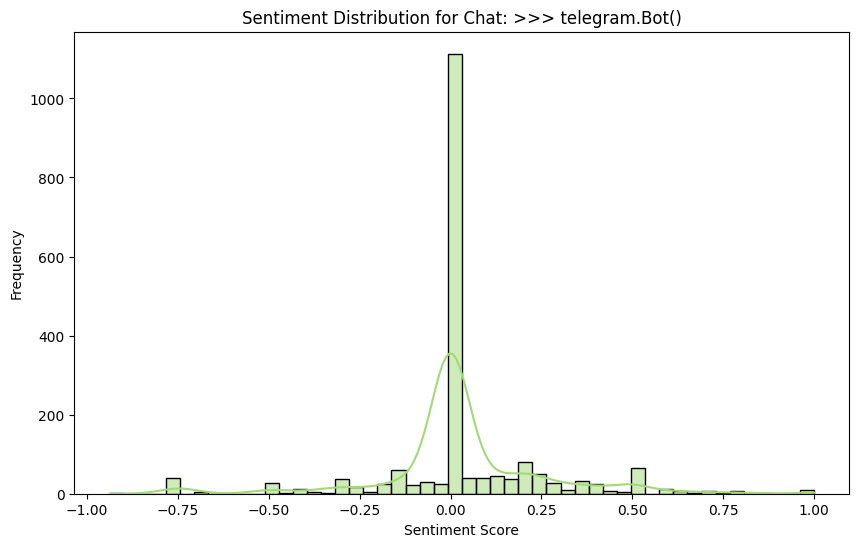

Average Sentiment for Chat: LobsterDAO ��: 0.09


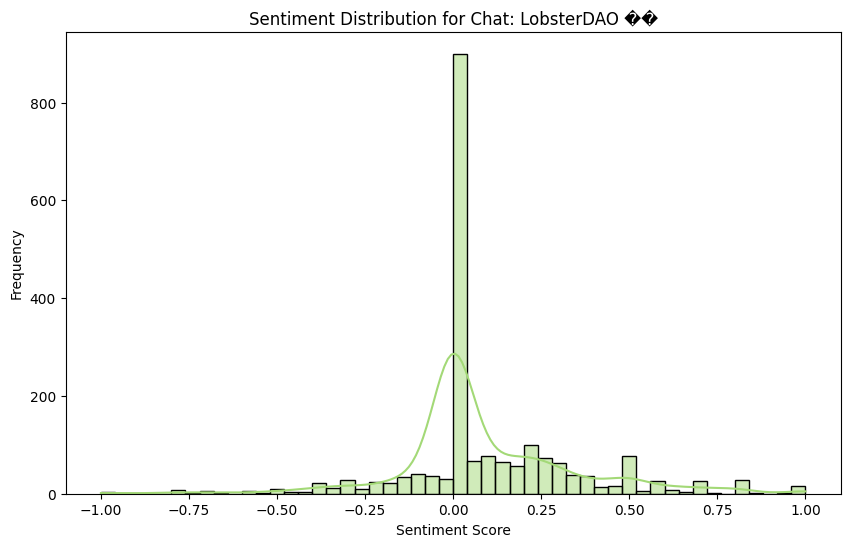

Average Sentiment for Chat: Binance English: 0.07


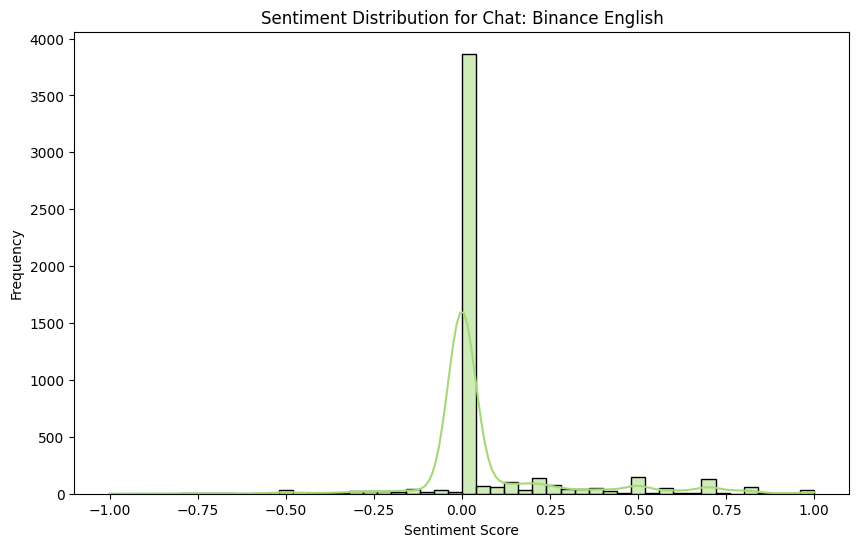

In [210]:
def analyze_sentiment(df, chat_info):
    # Rename columns in chat_info
    chat_info.columns = ['id', 'chat_name', 'members_count']
    chat_info['id'] = chat_info['id'].astype(int)  # Ensure id is integer for merging

    # Merge DataFrames
    merged_df = pd.merge(df, chat_info, left_on='chat_id', right_on='id', how='left')

    # Apply sentiment analysis to all messages
    merged_df['sentiment'] = merged_df['text'].apply(get_sentiment)

    # Perform sentiment analysis for each unique chat
    for chat_id in merged_df['chat_id'].unique():
        chat_messages = merged_df[merged_df['chat_id'] == chat_id]
        chat_name = chat_messages['chat_name'].iloc[0]

        avg_sentiment = chat_messages['sentiment'].mean()
        print(f"Average Sentiment for Chat: {chat_name}: {avg_sentiment:.2f}")

        # Plot sentiment distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(chat_messages['sentiment'], bins=50, kde=True)
        plt.title(f'Sentiment Distribution for Chat: {chat_name}')
        plt.xlabel('Sentiment Score')
        plt.ylabel('Frequency')
        plt.show()

    return merged_df

# Convert chat_info to DataFrame if it's not already
if not isinstance(chat_info, pd.DataFrame):
    chat_info = pd.DataFrame(chat_info)

# Call the function and get the updated DataFrame
human_messages_df = analyze_sentiment(human_messages_df, chat_info)



Top 5 Words for Each of the Top 5 Emotions in Chat: >>> telegram.Bot()
Emotion: positive
Top 5 Words:
abba, ability, abovementioned, absolute, absolution

Emotion: trust
Top 5 Words:
abacus, abbot, absolution, abundance, academic

Emotion: negative
Top 5 Words:
abandon, abandoned, abandonment, abduction, aberrant

Emotion: anticipation
Top 5 Words:
abundance, accelerate, accolade, accompaniment, achievement

Emotion: sadness
Top 5 Words:
abandon, abandoned, abandonment, abduction, abortion



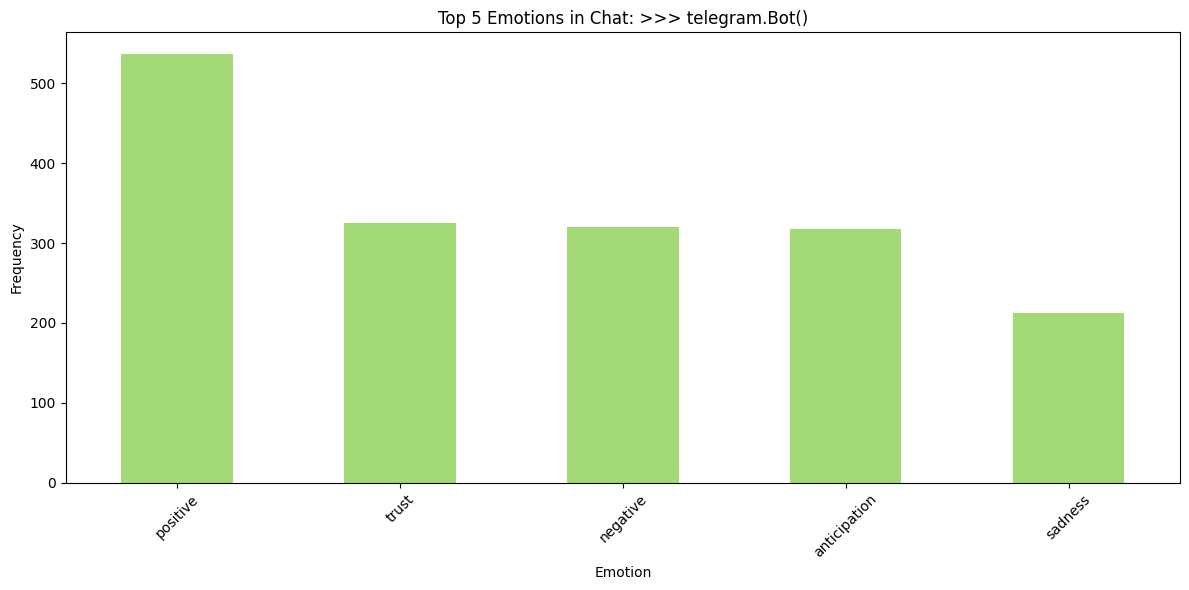

Top 5 Words for Each of the Top 5 Emotions in Chat: LobsterDAO ��
Emotion: positive
Top 5 Words:
abba, ability, abovementioned, absolute, absolution

Emotion: trust
Top 5 Words:
abacus, abbot, absolution, abundance, academic

Emotion: negative
Top 5 Words:
abandon, abandoned, abandonment, abduction, aberrant

Emotion: anticipation
Top 5 Words:
abundance, accelerate, accolade, accompaniment, achievement

Emotion: joy
Top 5 Words:
absolution, abundance, abundant, accolade, accompaniment



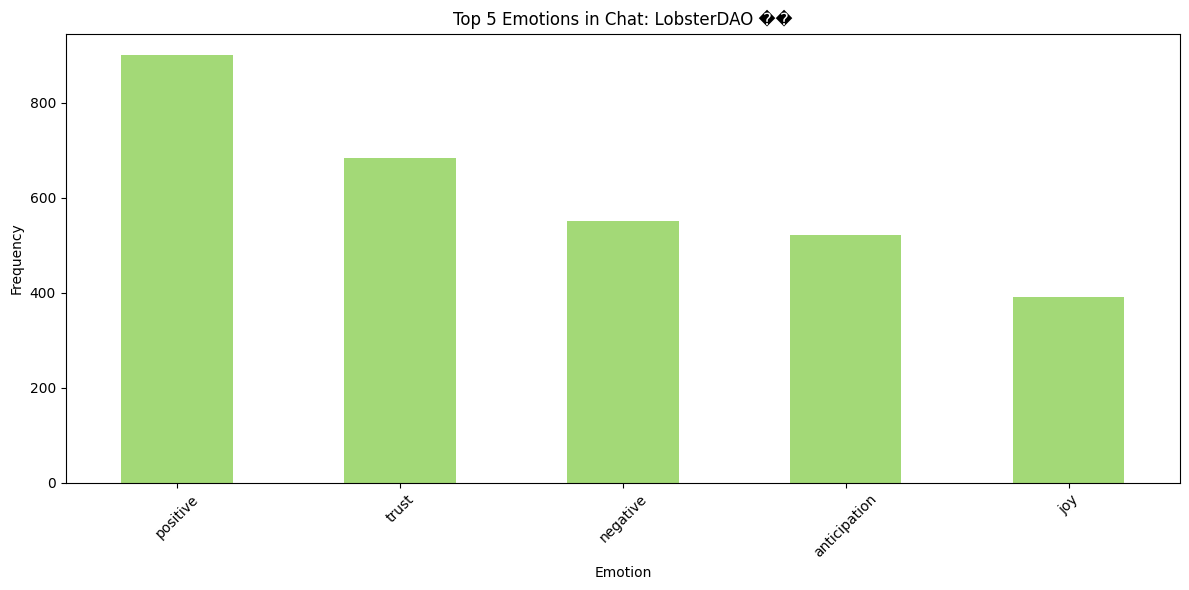

Top 5 Words for Each of the Top 5 Emotions in Chat: Binance English
Emotion: positive
Top 5 Words:
abba, ability, abovementioned, absolute, absolution

Emotion: trust
Top 5 Words:
abacus, abbot, absolution, abundance, academic

Emotion: anticipation
Top 5 Words:
abundance, accelerate, accolade, accompaniment, achievement

Emotion: joy
Top 5 Words:
absolution, abundance, abundant, accolade, accompaniment

Emotion: negative
Top 5 Words:
abandon, abandoned, abandonment, abduction, aberrant



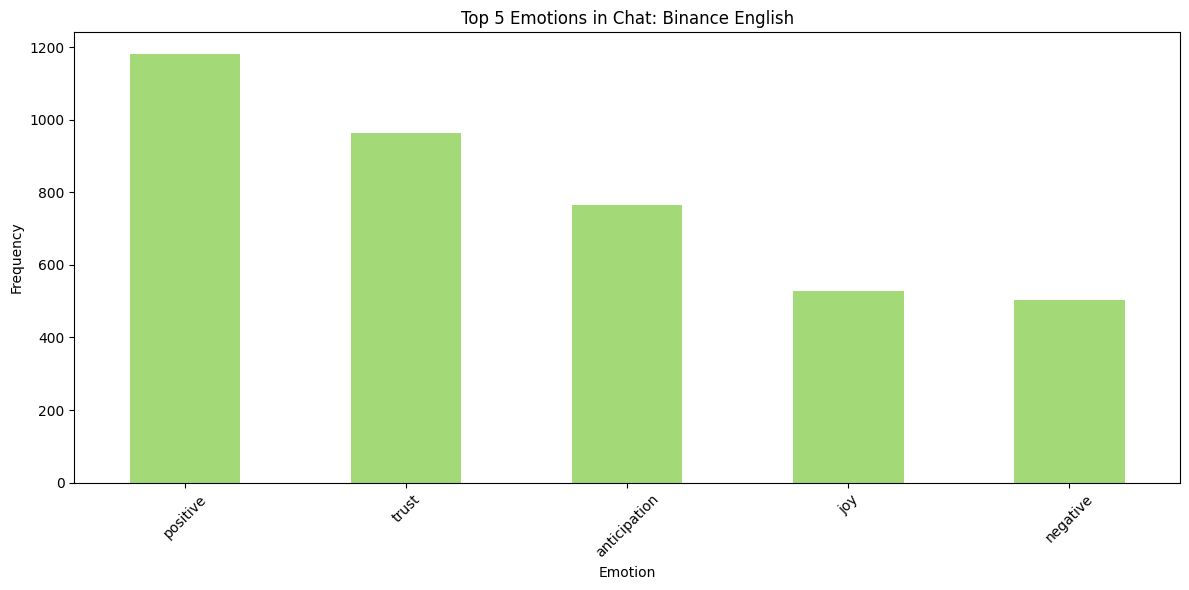

{1030379032: 0                                         {'positive': 1}
 1              {'positive': 4, 'negative': 2, 'trust': 3}
 2                             {'positive': 3, 'trust': 1}
 3                                                      {}
 4                                                      {}
                               ...                        
 8817                                                   {}
 8818                          {'anger': 1, 'negative': 1}
 9129                                                   {}
 9130    {'anticipation': 5, 'joy': 5, 'positive': 7, '...
 9131    {'anticipation': 2, 'joy': 2, 'positive': 3, '...
 Name: emotions, Length: 1929, dtype: object,
 1242127973: 86             {'trust': 1, 'negative': 1, 'positive': 1}
 87                                        {'positive': 1}
 88      {'anticipation': 2, 'joy': 2, 'positive': 3, '...
 89                                                     {}
 90                                        {'

In [218]:
def analyze_emotions(df, chat_info, nrc_lexicon):
    # Rename columns in chat_info
    chat_info.columns = ['id', 'chat_name', 'members_count']
    chat_info['id'] = chat_info['id'].astype(int)  # Ensure id is integer for merging

    # Merge DataFrames
    merged_df = pd.merge(df, chat_info, left_on='chat_id', right_on='id', how='left')

    all_chat_emotions = {}

    for chat_id in merged_df['chat_id'].unique():
        chat_messages = merged_df[merged_df['chat_id'] == chat_id]
        chat_name = chat_messages['chat_name_x'].iloc[0]

        # Emotion analysis
        chat_messages['emotions'] = chat_messages['text'].apply(get_emotions)
        emotion_counts = chat_messages['emotions'].explode().value_counts()

        # Print the top 5 words for each of the top 5 emotions for the current chat
        print(f"Top 5 Words for Each of the Top 5 Emotions in Chat: {chat_name}")
        for emotion, count in emotion_counts.sort_values(ascending=False).head(5).items():
            print(f"Emotion: {emotion}")
            print("Top 5 Words:")
            emotion_words = [word for word, emotion_scores in nrc_lexicon.items() if emotion in emotion_scores and emotion_scores[emotion] > 0]
            emotion_words.sort(key=lambda x: nrc_lexicon[x][emotion], reverse=True)
            print(", ".join(emotion_words[:5]))
            print()

        # Plot emotion distribution
        plt.figure(figsize=(12, 6))
        emotion_counts.head(5).plot(kind='bar')
        plt.title(f'Top 5 Emotions in Chat: {chat_name}')
        plt.xlabel('Emotion')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Store the emotions for this chat
        all_chat_emotions[chat_id] = chat_messages['emotions']

    return all_chat_emotions

# Convert chat_info to DataFrame if it's not already
if not isinstance(chat_info, pd.DataFrame):
    chat_info = pd.DataFrame(chat_info)

# Call the function and store the returned emotions
analyze_emotions(human_messages_df, chat_info, nrc_lexicon)



Domination emotion by day for each group

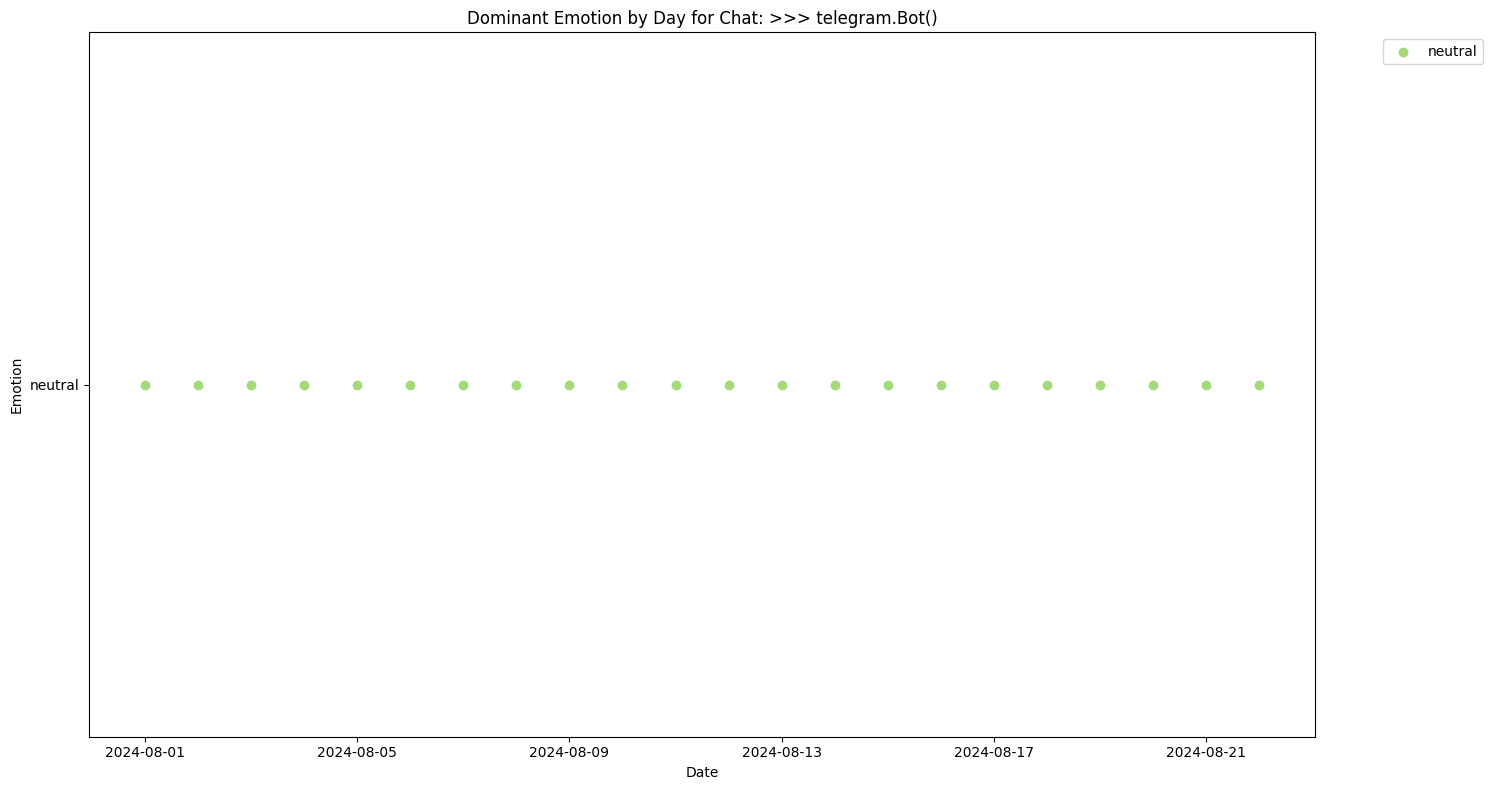

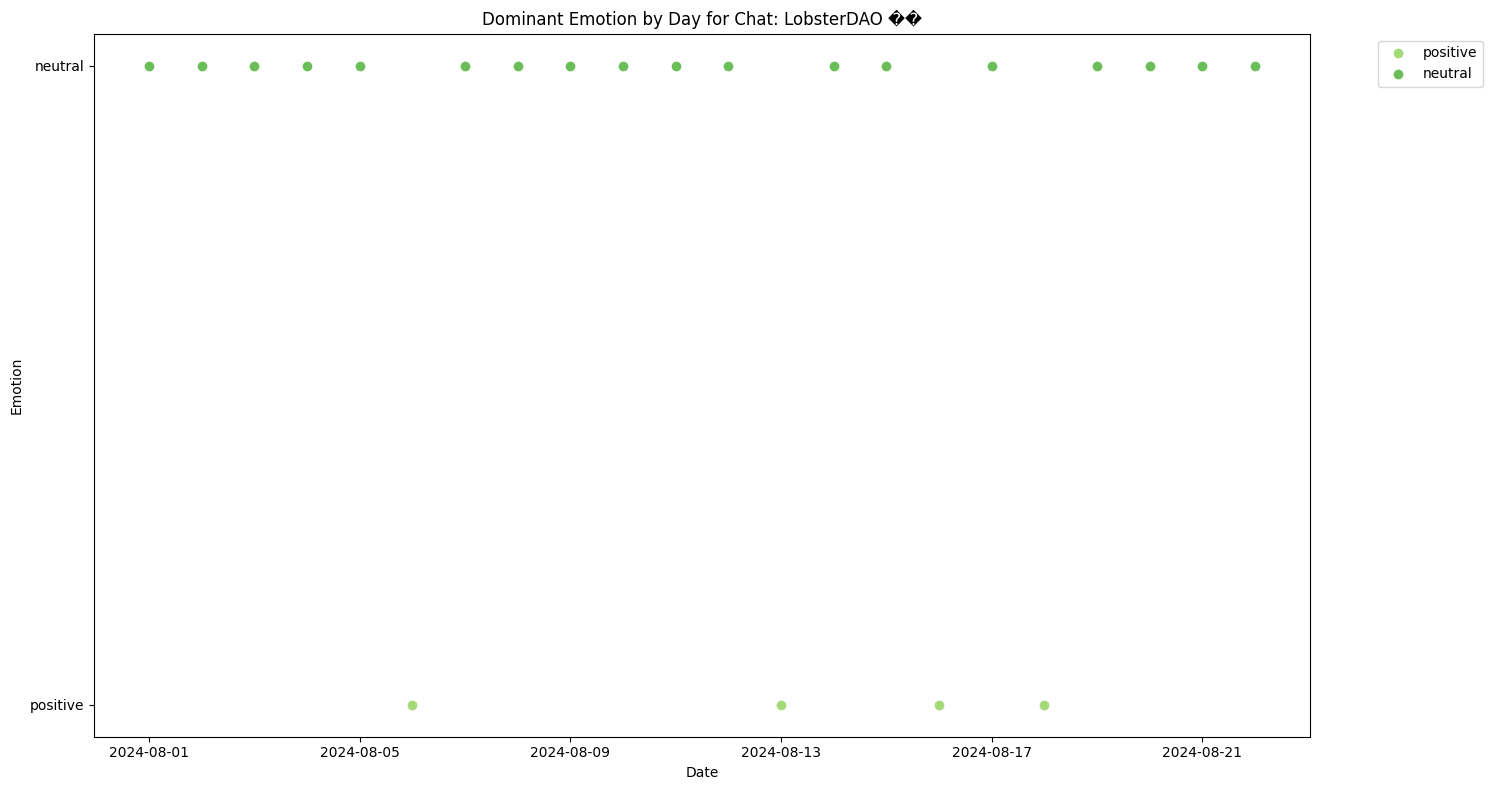

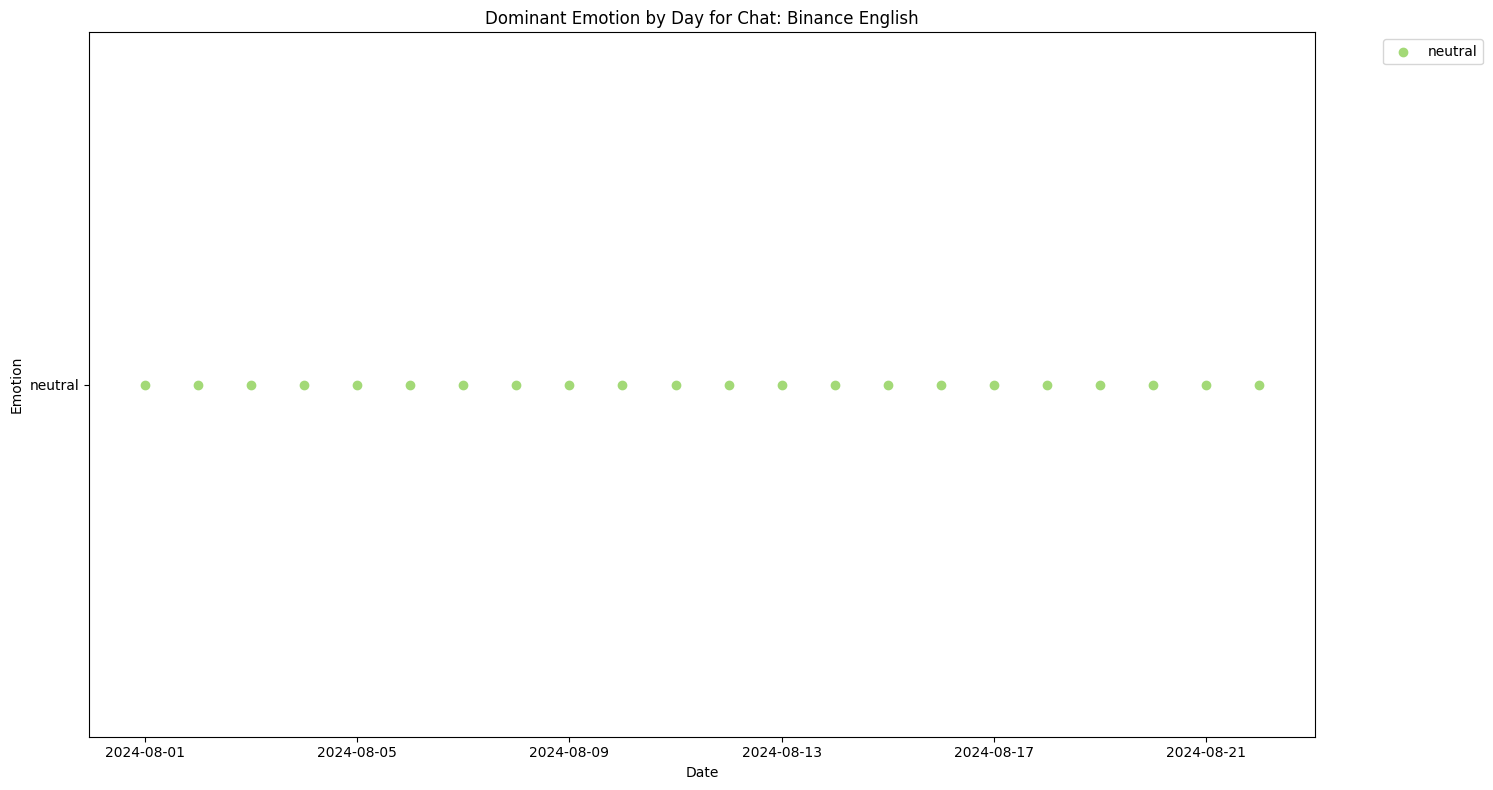

In [ ]:
def analyze_emotions_over_time(df, chat_info):
    # Ensure date column is datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Merge with chat_info to get chat names
    chat_info.columns = ['id', 'chat_name', 'members_count']
    chat_info['id'] = chat_info['id'].astype(int)
    df = pd.merge(df, chat_info, left_on='chat_id', right_on='id', how='left')

    # Function to get the dominant emotion
    def get_dominant_emotion(emotions):
        return max(emotions, key=emotions.get) if emotions else 'neutral'

    # Apply get_emotions to the 'text' column if not already done
    if 'emotions' not in df.columns:
        df['emotions'] = df['text'].apply(get_emotions)

    df['dominant_emotion'] = df['emotions'].apply(get_dominant_emotion)

    # Analyze and plot for each chat
    for chat_id in df['chat_id'].unique():
        chat_df = df[df['chat_id'] == chat_id]
        chat_name = chat_df['chat_name'].iloc[0]

        chat_df = chat_df.set_index('date')

        # Resample by day and get the most common emotion
        daily_emotion = chat_df['dominant_emotion'].resample('D').agg(lambda x: x.value_counts().index[0] if len(x) > 0 else 'neutral')

        # Plot emotions over time
        plt.figure(figsize=(15, 8))
        for emotion in set(daily_emotion.values):
            emotion_days = daily_emotion[daily_emotion == emotion].index
            plt.scatter(emotion_days, [emotion] * len(emotion_days), label=emotion)

        plt.title(f'Dominant Emotion by Day for Chat: {chat_name}')
        plt.xlabel('Date')
        plt.ylabel('Emotion')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Convert chat_info to DataFrame if it's not already
if not isinstance(chat_info, pd.DataFrame):
    chat_info = pd.DataFrame(chat_info)

# Call the function
analyze_emotions_over_time(human_messages_df, chat_info)

Correlation between sentiment and message length: 0.02


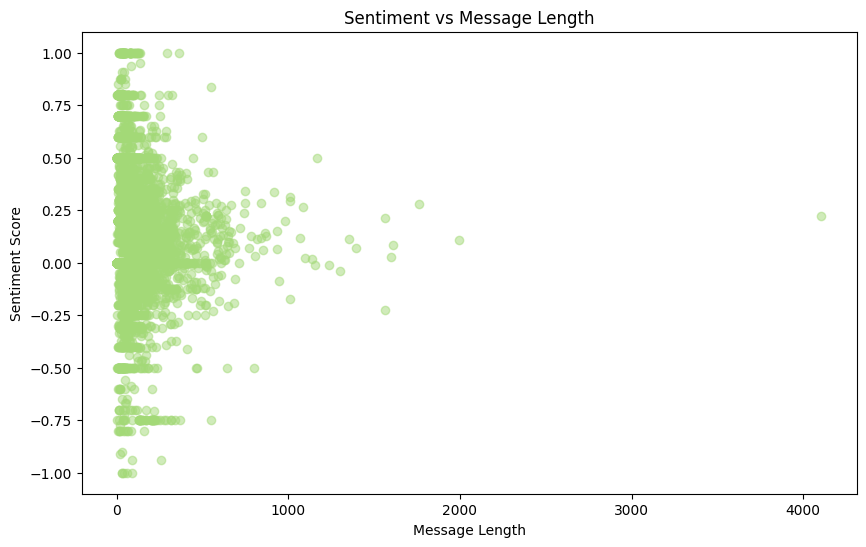

In [212]:
# Now you can proceed with the correlation analysis
human_messages_df['message_length'] = human_messages_df['text'].fillna('').astype(str).str.len()
correlation = human_messages_df['sentiment'].corr(human_messages_df['message_length'])
print(f"Correlation between sentiment and message length: {correlation:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(human_messages_df['message_length'], human_messages_df['sentiment'], alpha=0.5)
plt.title('Sentiment vs Message Length')
plt.xlabel('Message Length')
plt.ylabel('Sentiment Score')
plt.show()

In [ ]:
# Emotion analysis for top users
top_users = human_messages_df['from_user'].value_counts().head(5).index
for user in top_users:
    user_emotions = Counter()
    for emotions in human_messages_df[human_messages_df['from_user'] == user]['emotions']:
        user_emotions.update(emotions)
    
    print(f"\nTop 5 emotions for user {user}:")
    print(dict(user_emotions.most_common(5)))


Top 5 emotions for user 611740329:
{'positive': 233, 'trust': 184, 'anticipation': 157, 'negative': 88, 'joy': 58}

Top 5 emotions for user 140105449:
{'positive': 58, 'negative': 31, 'trust': 25, 'anticipation': 23, 'fear': 20}

Top 5 emotions for user 7226176635:
{'positive': 95, 'trust': 56, 'anticipation': 40, 'negative': 25, 'joy': 12}

Top 5 emotions for user 375542731:
{'positive': 96, 'trust': 74, 'anticipation': 43, 'negative': 43, 'fear': 30}

Top 5 emotions for user 5219625520:
{'positive': 61, 'trust': 46, 'anticipation': 44, 'joy': 35, 'surprise': 15}


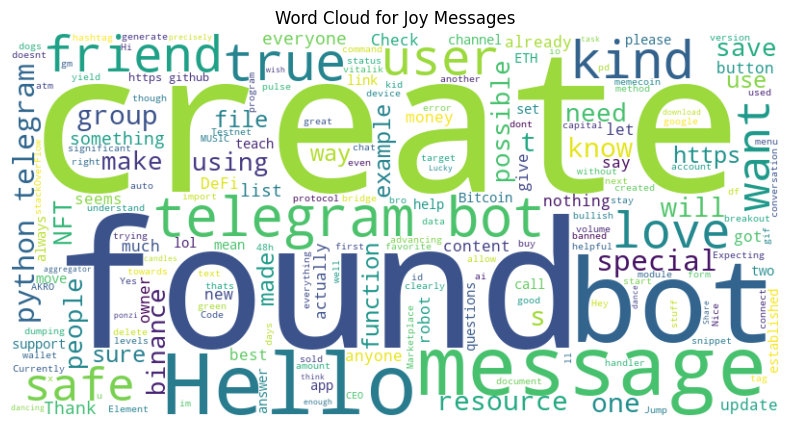

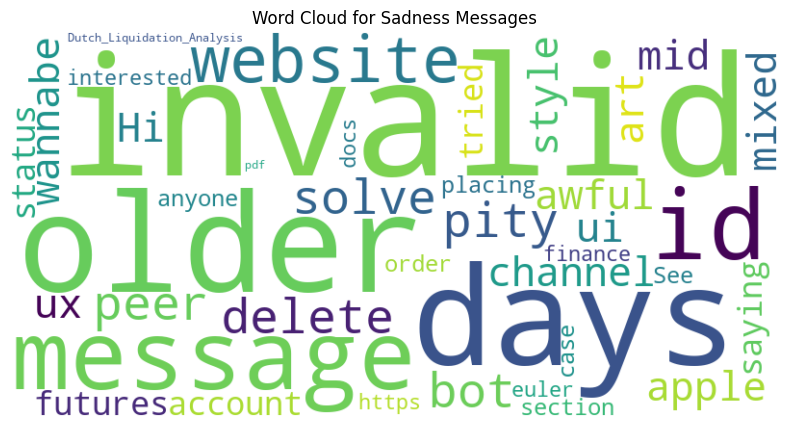

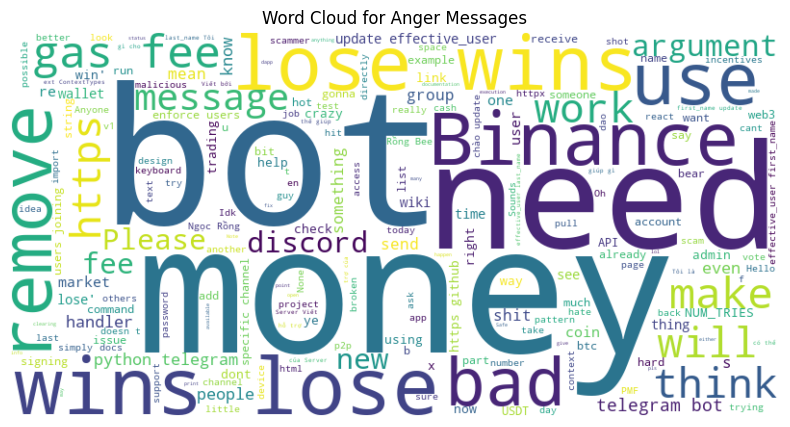

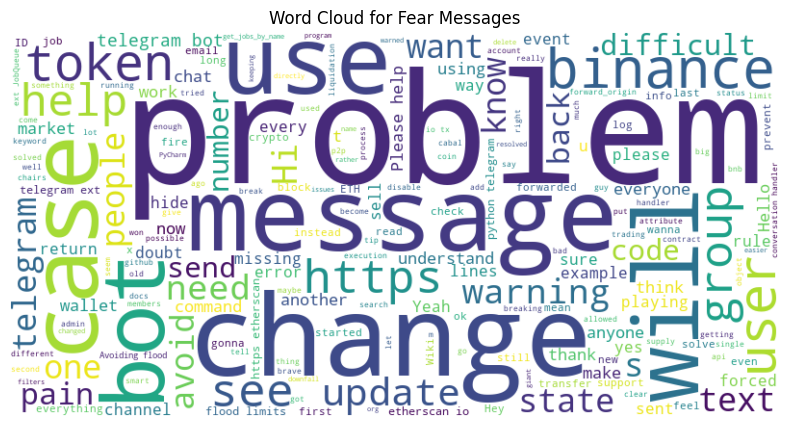

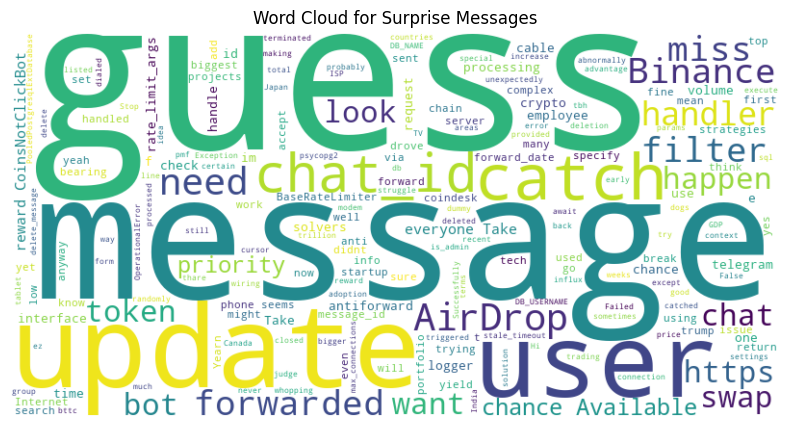

In [ ]:
# Word cloud for each emotion

for emotion in ['joy', 'sadness', 'anger', 'fear', 'surprise']:
    emotion_words = ' '.join(human_messages_df[human_messages_df['dominant_emotion'] == emotion]['text'].fillna('').astype(str))
    if emotion_words.strip():  # Check if there are any words for this emotion
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_words)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {emotion.capitalize()} Messages')
        plt.show()
    else:
        print(f"No words found for emotion: {emotion}")

## User analysis

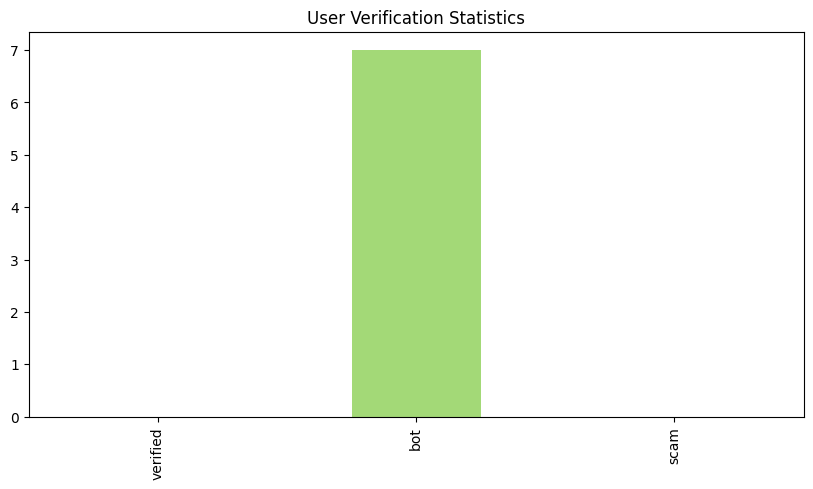

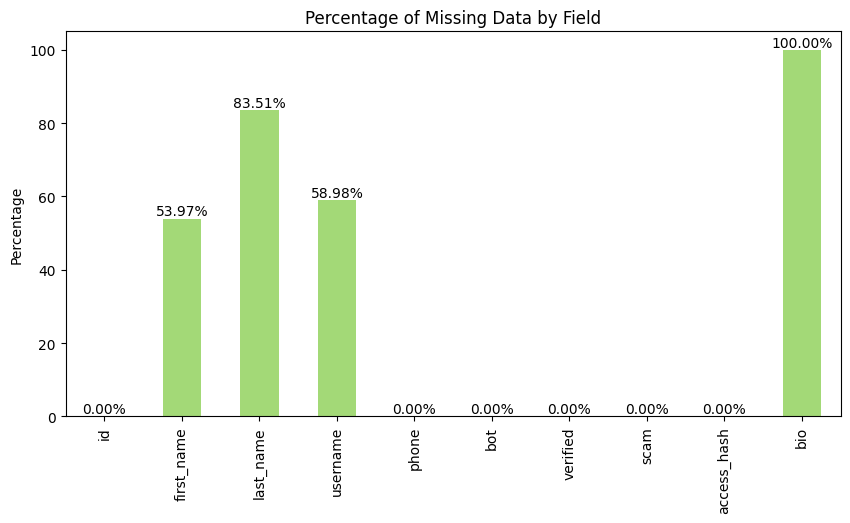

Percentage of bots: 0.35%


In [ ]:

verification_stats = user_info_df[['verified', 'bot', 'scam']].sum()
plt.figure(figsize=(10, 5))
verification_stats.plot(kind='bar')
plt.title('User Verification Statistics')
plt.show()

# 6. Data Quality and Completeness
missing_data = user_info_df.isnull().sum() / len(user_info_df) * 100
plt.figure(figsize=(10, 5))
ax = missing_data.plot(kind='bar')
plt.title('Percentage of Missing Data by Field')
plt.ylabel('Percentage')

# Add percentage on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()


# 7. Bot Detection and Analysis
bot_percentage = (user_info_df['bot'].sum() / len(user_info_df)) * 100
print(f"Percentage of bots: {bot_percentage:.2f}%")